# Twitter Sentiment Analysis with Machine Learning Models

This notebook performs sentiment analysis on Twitter data using various machine learning models, including a neural network, Random Forest, XGBoost, and Decision Tree classifiers. It includes hyperparameter tuning, model comparison, and feature importance visualization.


### Import Libraries
In this section, we import the necessary libraries for data manipulation, visualization, natural language processing, machine learning, and deep learning.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
import pickle
import re
from collections import Counter
from tensorflow.keras.regularizers import l2

#### NLTK Stopwords

In this sentiment analysis project, we utilize the NLTK library to handle stopwords, which are commonly used words such as "is," "the," and "and" that carry little meaningful information on their own. Removing these stopwords from our dataset is crucial as it reduces noise, enhances computational efficiency, and improves model performance by allowing the focus to be on more significant words that better convey sentiment. By eliminating these frequent but insignificant words, we ensure that our text data is cleaner and more manageable, thereby enabling our machine learning models to more accurately capture and analyze the sentiment within the Twitter tweets from India.

In [8]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91798\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the Data
Load the Twitter dataset and display its shape to understand its structure.


In [9]:
data = pd.read_csv(r'text_emotion.csv')
print(f"Dataset shape : {data.shape}")

Dataset shape : (40000, 4)


### Generate Wordcloud
Combine all reviews to generate a wordcloud, providing a visual representation of the most common words in the dataset.


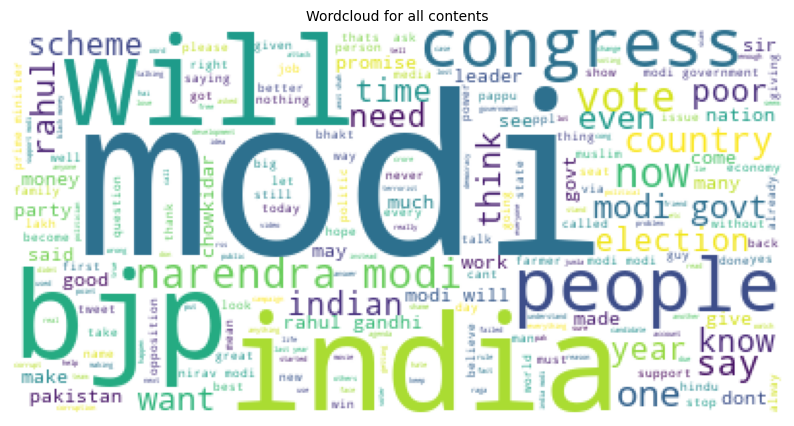

In [10]:
contents = " ".join([review for review in data['content']])
wc = WordCloud(background_color='white', max_words=500)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(contents))
plt.title('Wordcloud for all contents', fontsize=10)
plt.axis('off')
plt.show()

### Combine Contents by Sentiment Category
Aggregate the contents of tweets by their sentiment category to analyze word usage per category.

In [11]:
contents_dict = {}
for i in data['sentiment'].unique():
    contents_dict[i] = " ".join([contents for contents in data[data['sentiment'] == i]['content']])
    contents_dict[i] = contents_dict[i].lower().split()

### Find Unique Words Per Sentiment Category
Identify and visualize unique words for each sentiment category to understand distinctive word patterns.


In [12]:
contents_uniqe_dict = {}
for i in data['sentiment'].unique():
    remain_dict = {key: value for key, value in contents_dict.items() if key != i}
    contents_uniqe_dict[i] = [x for x in contents_dict[i] if x not in remain_dict.values()]
    contents_uniqe_dict[i] = " ".join(contents_uniqe_dict[i])

### Preprocess the Data and Identify Common Words
Preprocess the tweets by cleaning and stemming the text, and identify the most common words across the entire dataset.


In [13]:
corpus = []
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
all_words = []
for content in data['content']:
    content = re.sub('[^a-zA-Z]', ' ', str(content))
    content = content.lower().split()
    all_words.extend(content)

word_counts = Counter(all_words)
most_common_words = [word for word, count in word_counts.most_common(100)]

for i in range(data.shape[0]):
    content = re.sub('[^a-zA-Z]', ' ', str(data.iloc[i]['content']))
    content = content.lower().split()
    content = [stemmer.stem(word) for word in content if word not in stop_words and word not in most_common_words]
    content = ' '.join(content)
    corpus.append(content)

Tokenize and Pad Sequences
- Tokenize the cleaned text and pad the sequences to ensure uniform input length for the neural network model.

Split the Data
- Split the dataset into training and testing sets to evaluate model performance.

Encode the Labels
- Encode the sentiment labels into numerical format to use in machine learning models.

In [14]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen=100)
y = data['sentiment'].values

pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

### Neural Network Model in This Project

In this project, we utilize a neural network to perform sentiment analysis on Twitter tweets. The neural network architecture includes the following components:

1. **Embedding Layer**:
   - Converts input sequences into dense vectors of fixed size.
   - Captures semantic relationships between words.

2. **SpatialDropout1D Layer**:
   - Prevents overfitting by randomly setting a fraction of input units to zero at each update during training.

3. **LSTM Layer**:
   - Captures long-term dependencies and temporal patterns in the sequential data.
   - Processes input sequences to understand the context of words.

4. **Dense Layers**:
   - The first dense layer uses ReLU activation to learn complex patterns.
   - The final dense layer uses softmax activation to output a probability distribution over sentiment classes.

5. **Dropout Layers**:
   - Prevent overfitting by randomly dropping neurons during training.

6. **Early Stopping**:
   - Monitors validation loss and stops training when the model stops improving.

In [15]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=100),
    SpatialDropout1D(0.5),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

#### Compile the Model
Compile the neural network model with Adam optimizer and sparse categorical cross-entropy loss function.

In [15]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Train the Model with Early Stopping
Train the neural network model with early stopping to prevent overfitting and optimize training time.

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train_encoded, epochs=15, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/15
700/700 [==============================] - 193s 273ms/step - loss: 1.5378 - accuracy: 0.5063 - val_loss: 1.2839 - val_accuracy: 0.5300
Epoch 2/15
700/700 [==============================] - 204s 291ms/step - loss: 1.1545 - accuracy: 0.5532 - val_loss: 1.0407 - val_accuracy: 0.5680
Epoch 3/15
700/700 [==============================] - 201s 287ms/step - loss: 0.9233 - accuracy: 0.6297 - val_loss: 0.8577 - val_accuracy: 0.6480
Epoch 4/15
700/700 [==============================] - 194s 277ms/step - loss: 0.7921 - accuracy: 0.6799 - val_loss: 0.7878 - val_accuracy: 0.6745
Epoch 5/15
700/700 [==============================] - 198s 282ms/step - loss: 0.7293 - accuracy: 0.7063 - val_loss: 0.7462 - val_accuracy: 0.6963
Epoch 6/15
700/700 [==============================] - 183s 261ms/step - loss: 0.6820 - accuracy: 0.7302 - val_loss: 0.7357 - val_accuracy: 0.7066
Epoch 7/15
700/700 [==============================] - 183s 262ms/step - loss: 0.6345 - accuracy: 0.7589 - val_loss: 0.6910 -

#### Evaluate the Model
Evaluate the trained neural network model on the test set and display the test accuracy.

In [17]:
evaluation = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {evaluation[1]}")

375/375 [==============================] - 18s 49ms/step - loss: 0.6031 - accuracy: 0.7966
Test Accuracy: 0.796583354473114


#### Plot Accuracy and Loss Curves
Plot the accuracy and loss curves to visualize the model's training and validation performance.

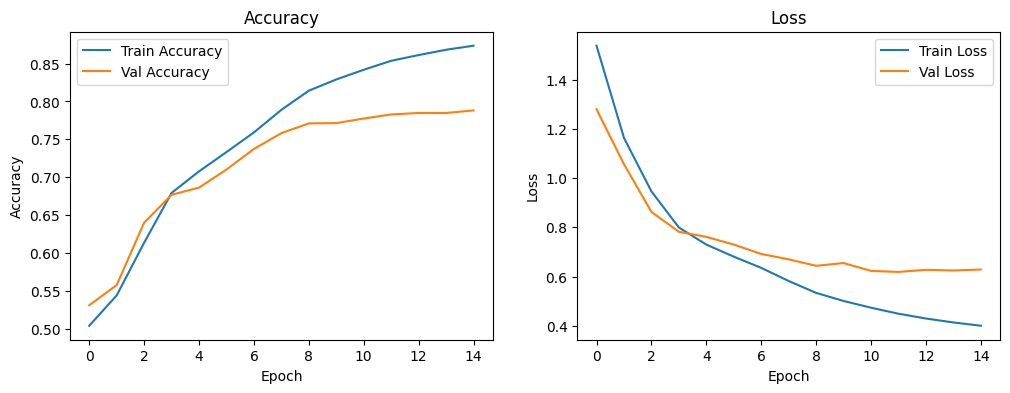

In [15]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


#### Generate Confusion Matrix
Generate and display the confusion matrix for the neural network model to analyze its performance in classifying sentiments.

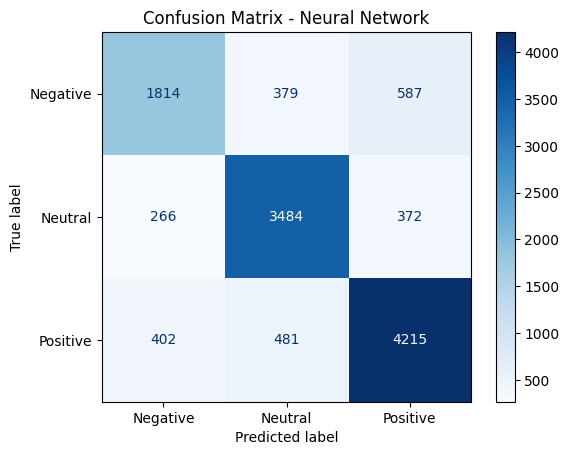

In [16]:
y_pred_nn = model.predict(X_test)
y_pred_classes_nn = np.argmax(y_pred_nn, axis=1)

conf_matrix_nn = confusion_matrix(y_test_encoded, y_pred_classes_nn)
conf_matrix_display_nn = ConfusionMatrixDisplay(conf_matrix_nn, display_labels=label_encoder.classes_)
conf_matrix_display_nn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Neural Network')
plt.show()

#### Save the model

In [17]:
model.save('nn_model.h5')

### Predicting Sentiment of New Tweets

After training our neural network model, we can use it to predict the sentiment of new tweets. The process involves the following steps:


In [2]:
def predict_sentiment(tweet):
    # Load the saved tokenizer
    tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))
    
    # Preprocess the tweet
    content = re.sub('[^a-zA-Z]', ' ', tweet)
    content = content.lower().split()
    stop_words = set(stopwords.words('english'))
    content = [PorterStemmer().stem(word) for word in content if word not in stop_words]
    content = ' '.join(content)
    
    # Convert the tweet to sequence and pad it
    sequence = tokenizer.texts_to_sequences([content])
    padded_sequence = pad_sequences(sequence, maxlen=100)
    
    # Load the saved model
    model = Sequential([
        Embedding(input_dim=10000, output_dim=100, input_length=100),
        SpatialDropout1D(0.5),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(len(np.unique(y)), activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('nn_model.h5')  # Assuming you saved the model weights
    
    # Make prediction
    prediction = model.predict(padded_sequence)
    sentiment = np.argmax(prediction, axis=1)
    
    # Map sentiment to class labels
    sentiment_labels = label_encoder.classes_
    return sentiment_labels[sentiment[0]]

In [2]:
tweet = "I love the new features of the app! It's fantastic."
predicted_sentiment = predict_sentiment(tweet)
print("Tweet : I love the new features of the app! It's fantastic.")
print("1: Positive, 0: Negative")
print(f"The sentiment of the tweet is: {predicted_sentiment}")



Tweet : I love the new features of the app! It's fantastic.
1: Positive, 0: Negative
The sentiment of the tweet is: 1
    


### Train Random Forest Classifier with Hyperparameter Tuning
Train a Random Forest classifier with hyperparameter tuning using RandomizedSearchCV and evaluate its performance.


In [18]:
rf = RandomForestClassifier(random_state=42)
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train_encoded)

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Classifier")
print(classification_report(y_test_encoded, y_pred_rf))

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.73      0.04      0.07      2780
           1       0.60      0.60      0.60      4122
           2       0.52      0.78      0.63      5098

    accuracy                           0.55     12000
   macro avg       0.62      0.48      0.43     12000
weighted avg       0.60      0.55      0.49     12000



#### Save the model

In [19]:
# Save the trained Random Forest model
pickle.dump(best_rf, open('Models/model_rf.pkl', 'wb'))

### Train XGBoost Classifier with Hyperparameter Tuning
Train an XGBoost classifier with hyperparameter tuning using RandomizedSearchCV and evaluate its performance.

In [ ]:
# XGBoost Classifier with expanded hyperparameter tuning
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', random_state=42)
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

random_search_xgb = RandomizedSearchCV(xgb_clf, param_distributions=param_dist_xgb, n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train_encoded)

best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Classifier")
print(classification_report(y_test_encoded, y_pred_xgb))

#### Save the model

In [ ]:
# Save the trained XGBoost model
pickle.dump(best_xgb, open('Models/model_xgb.pkl', 'wb'))

### Train Decision Tree Classifier with Hyperparameter Tuning
Train a Decision Tree classifier with hyperparameter tuning using GridSearchCV and evaluate its performance.


In [ ]:
# Train Decision Tree Classifier with hyperparameter tuning
dt = DecisionTreeClassifier(random_state=42)
param_dist_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(dt, param_grid=param_dist_dt, cv=3, n_jobs=-1)
grid_search_dt.fit(X_train, y_train_encoded)

best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
print("Decision Tree Classifier")
print(classification_report(y_test_encoded, y_pred_dt))

In [ ]:
# Save the trained Decision Tree model
pickle.dump(best_dt, open('Models/model_dt.pkl', 'wb'))

## Compare Model Performance
Compare the accuracy of the neural network, Random Forest, XGBoost, and Decision Tree models using a bar plot.


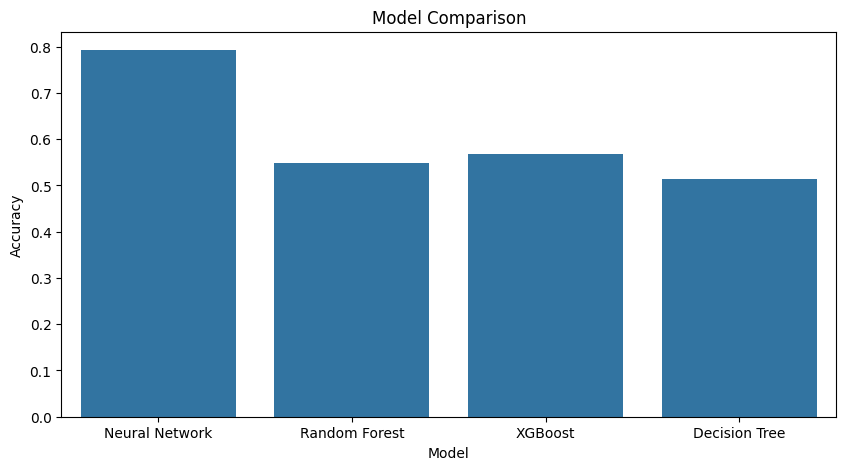

In [34]:
# Cell 20: Compare model performance
models = ['Neural Network', 'Random Forest', 'XGBoost', 'Decision Tree']
accuracies = [
    accuracy_score(y_test_encoded, y_pred_classes_nn),
    accuracy_score(y_test_encoded, y_pred_rf),
    accuracy_score(y_test_encoded, y_pred_xgb),
    accuracy_score(y_test_encoded, y_pred_dt)
]

plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=accuracies)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

### Feature Importance for Tree-Based Models
Visualize the feature importance for the best-performing Random Forest, XGBoost, and Decision Tree models to understand which words are most influential in predicting sentiment.

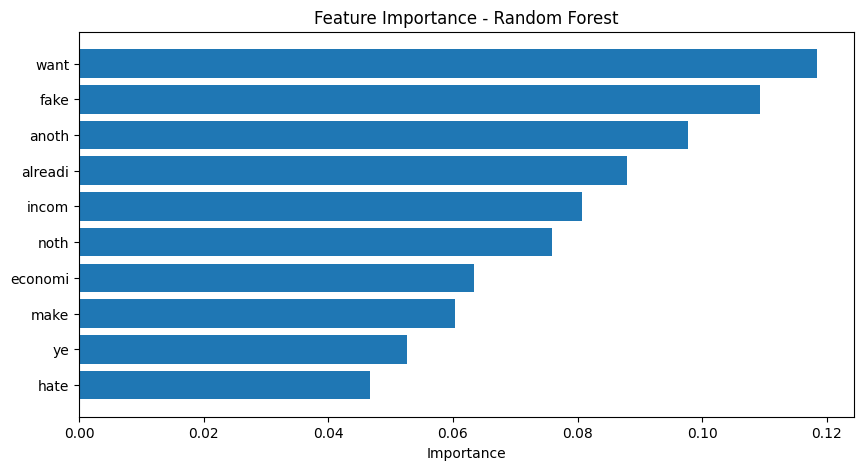

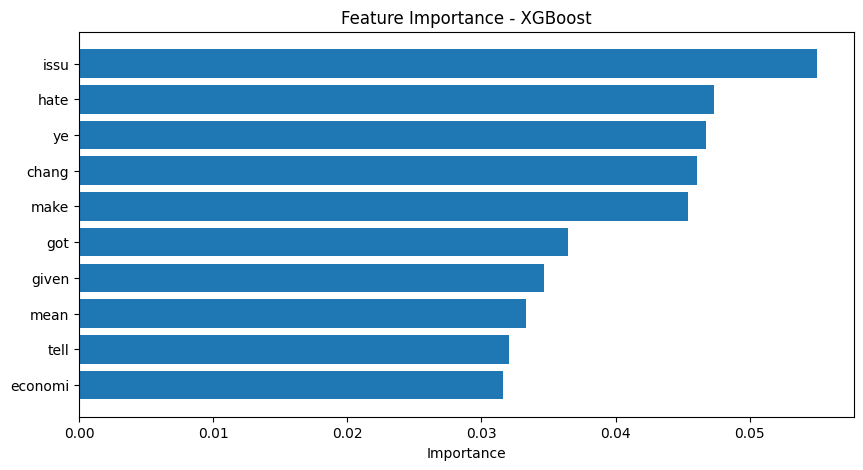

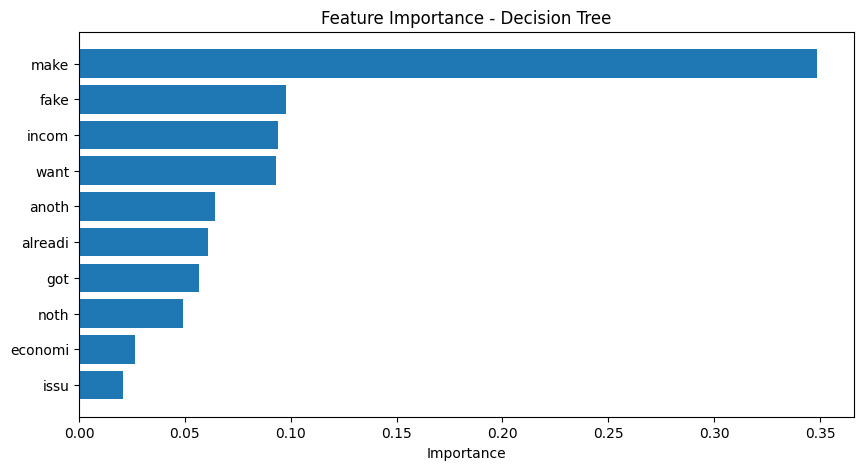

In [35]:
# Random Forest Feature Importance
importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[-10:]

plt.figure(figsize=(10, 5))
plt.title('Feature Importance - Random Forest')
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), [tokenizer.index_word[i] for i in indices_rf])
plt.xlabel('Importance')
plt.show()

# XGBoost Feature Importance
importances_xgb = best_xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[-10:]

plt.figure(figsize=(10, 5))
plt.title('Feature Importance - XGBoost')
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align='center')
plt.yticks(range(len(indices_xgb)), [tokenizer.index_word[i] for i in indices_xgb])
plt.xlabel('Importance')
plt.show()

# Decision Tree Feature Importance
importances_dt = best_dt.feature_importances_
indices_dt = np.argsort(importances_dt)[-10:]

plt.figure(figsize=(10, 5))
plt.title('Feature Importance - Decision Tree')
plt.barh(range(len(indices_dt)), importances_dt[indices_dt], align='center')
plt.yticks(range(len(indices_dt)), [tokenizer.index_word[i] for i in indices_dt])
plt.xlabel('Importance')
plt.show()